In [1]:
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, ggplot2)
library(Matching)
library(dplyr)
library(marginaleffects)
library(MatchIt)

# Load master dataset
ma_final <- read_csv("../../hwk2/data/output/final_ma_data.csv")

Loading required package: pacman

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


## 
##  Matching (Version 4.10-15, Build Date: 2024-10-14)
##  See https://www.jsekhon.com for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##


Rows: 449046 Columns: 68
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (18): contractid, state, county, org_type, plan_type, partd, snp, eghp, ...
dbl (50): source_year, planid, fips, year, n_nonmiss, avg_enrollment, n_elig...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Question 1

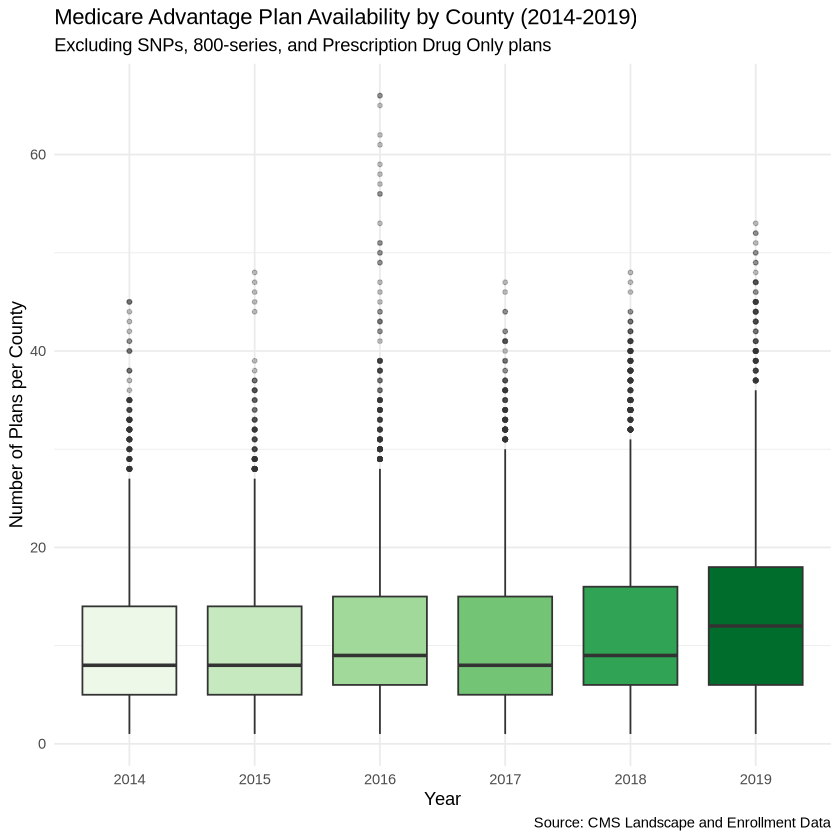

In [2]:
# Filter
ma_summary <- ma_final %>%
  filter(
    snp == "No",                                   # Remove SNPs
    (as.numeric(planid) < 800 | as.numeric(planid) >= 900), # Remove 800-series
    !is.na(premium)                                # Part C only (removes PDPs)
  )
# Calculate counts per county/year
county_counts <- ma_summary %>%
  group_by(fips, year) %>%
  summarize(plan_count = n(), .groups = "drop")

# Make Whisker Plot
ggplot(county_counts, aes(x = as.factor(year), y = plan_count, fill = as.factor(year))) +
  geom_boxplot(outlier.size = 1, outlier.alpha = 0.3) +
  scale_fill_brewer(palette = "Greens") +
  labs(
    title = "Medicare Advantage Plan Availability by County (2014-2019)",
    subtitle = "Excluding SNPs, 800-series, and Prescription Drug Only plans",
    x = "Year",
    y = "Number of Plans per County",
    caption = "Source: CMS Landscape and Enrollment Data"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

# Question 2

# A tibble: 2 × 5
   year Mean_Annual_Bid Median_Annual_Bid SD_Annual_Bid Total_Obs
  <dbl>           <dbl>             <dbl>         <dbl>     <int>
1  2014          10551.            10340.         1765.     27574
2  2018           9357.             9206.         1471.     31855


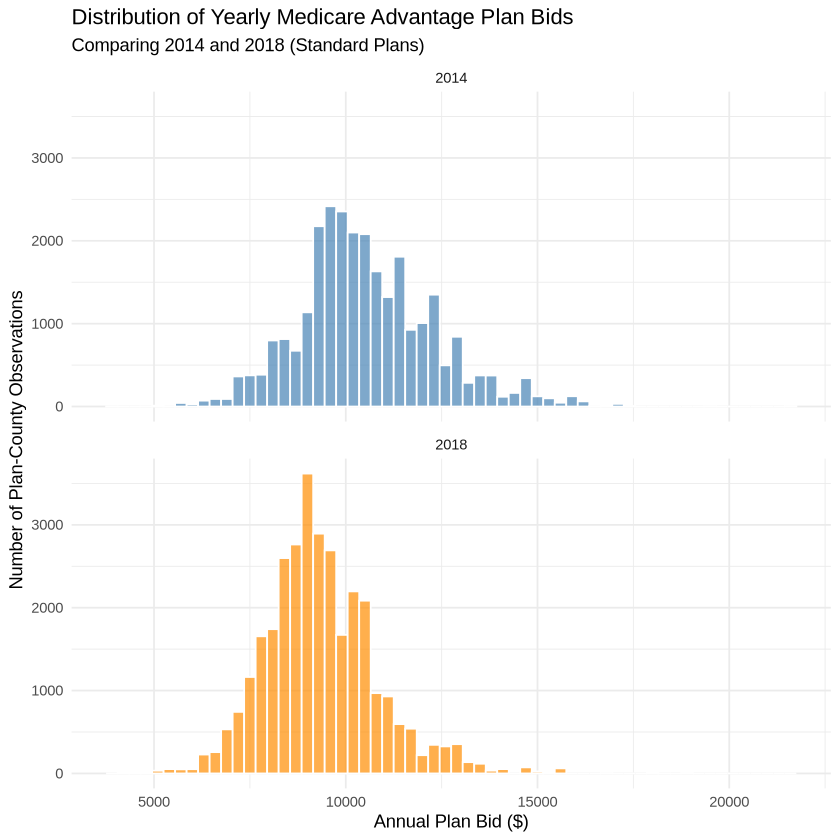

In [3]:
# Prepare data for 2014 and 2018 with Annualization
bid_comparison <- ma_summary %>%
  filter(
    year %in% c(2014, 2018),
    snp == "No",                                   
    (as.numeric(planid) < 800 | as.numeric(planid) >= 900), 
    !is.na(premium)                                
  ) %>%
  # --- CONVERT TO YEARLY ---
  mutate(yearly_bid = bid * 12) %>%
  # -------------------------
  # Filter based on yearly values (using $24,000 as a reasonable upper limit)
  filter(!is.na(yearly_bid), yearly_bid > 0, yearly_bid < 24000) 

# Create histograms
ggplot(bid_comparison, aes(x = yearly_bid, fill = as.factor(year))) +
  geom_histogram(binwidth = 300, alpha = 0.7, color = "white", position = "identity") +
  facet_wrap(~year, ncol = 1) +
  scale_fill_manual(values = c("2014" = "steelblue", "2018" = "darkorange")) +
  labs(
    title = "Distribution of Yearly Medicare Advantage Plan Bids",
    subtitle = "Comparing 2014 and 2018 (Standard Plans)",
    x = "Annual Plan Bid ($)",
    y = "Number of Plan-County Observations",
  ) +
  theme_minimal() +
  theme(legend.position = "none")

# Calculate yearly summary stats
bid_summary_table <- bid_comparison %>%
  group_by(year) %>%
  summarize(
    Mean_Annual_Bid = mean(yearly_bid, na.rm = TRUE),
    Median_Annual_Bid = median(yearly_bid, na.rm = TRUE),
    SD_Annual_Bid = sd(yearly_bid, na.rm = TRUE),
    Total_Obs = n()
  )

print(bid_summary_table)

year,Mean_Bid,Median_Bid,SD_Bid,Total_Obs
<dbl>,<dbl>,<dbl>,<dbl>,<int>
2014,879.2834,861.6301,147.1013,27574
2018,779.7197,767.1708,122.5830,31855


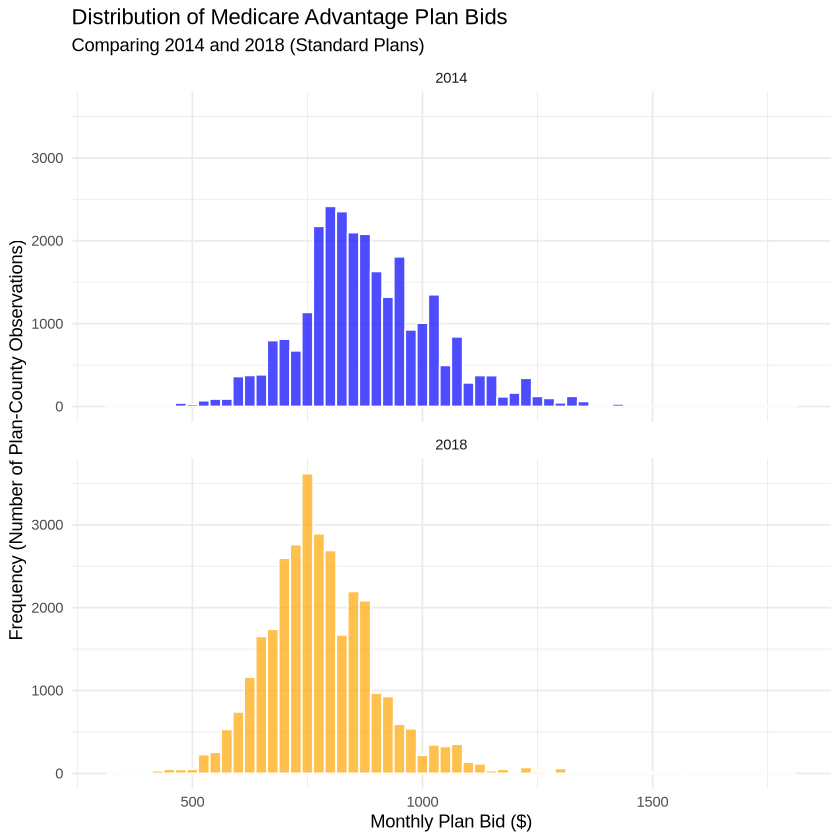

In [3]:
# Prepare data for 2014 and 2018
bid_comparison <- ma_summary %>%
  filter(
    year %in% c(2014, 2018),
    snp == "No",                                   # Standard plans only
    (as.numeric(planid) < 800 | as.numeric(planid) >= 900), # Remove 800-series
    !is.na(premium)                                # Part C benefits present
  ) %>%
  filter(!is.na(bid), bid > 0, bid < 2000) # Remove NAs and extreme outliers for clarity

# Create histograms
ggplot(bid_comparison, aes(x = bid, fill = as.factor(year))) +
  geom_histogram(binwidth = 25, alpha = 0.7, color = "white", position = "identity") +
  facet_wrap(~year, ncol = 1) +
  scale_fill_manual(values = c("2014" = "blue", "2018" = "orange")) +
  labs(
    title = "Distribution of Medicare Advantage Plan Bids",
    subtitle = "Comparing 2014 and 2018 (Standard Plans)",
    x = "Monthly Plan Bid ($)",
    y = "Frequency (Number of Plan-County Observations)",
  ) +
  theme_minimal() +
  theme(legend.position = "none")

# Calculate summary stats
bid_comparison %>%
  group_by(year) %>%
  summarize(
    Mean_Bid = mean(bid, na.rm = TRUE),
    Median_Bid = median(bid, na.rm = TRUE),
    SD_Bid = sd(bid, na.rm = TRUE),
    Total_Obs = n()
  )

# Question 3

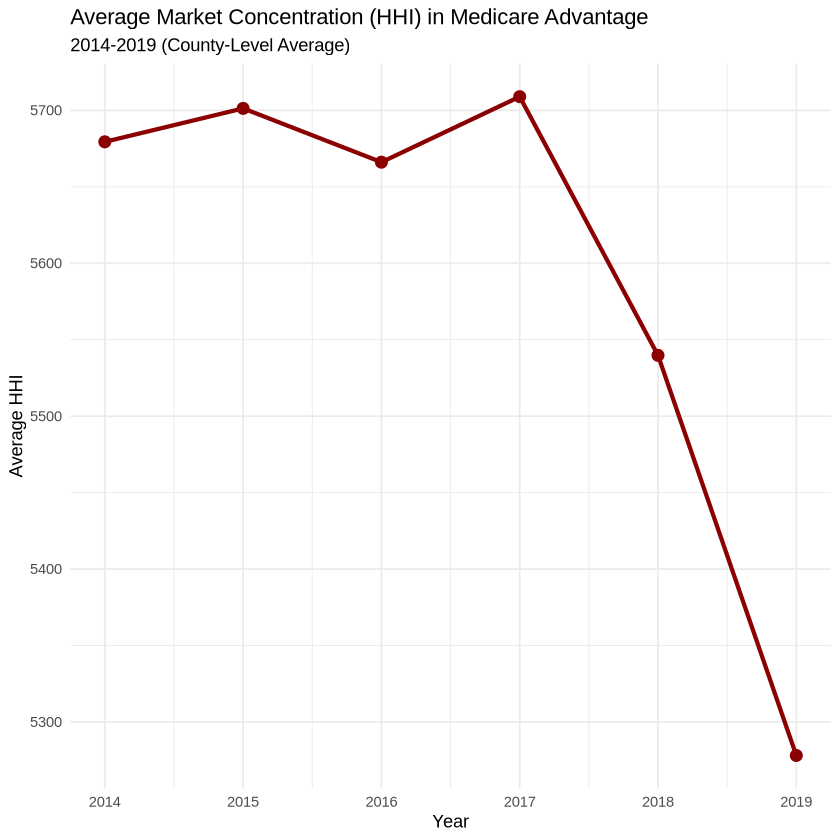

In [6]:
# Prepare Enrollment Data
county_shares <- ma_summary %>% # Use filtered data
  group_by(fips, year, parent_org) %>%
  summarize(org_enrollment = sum(avg_enrollment, na.rm = TRUE), .groups = "drop_last") %>%
  mutate(
    total_county_enrollment = sum(org_enrollment, na.rm = TRUE),
    share = (org_enrollment / total_county_enrollment) * 100
  ) %>%
  filter(total_county_enrollment > 0) %>%
  ungroup()

# Calculate HHI per county per year
county_hhi <- county_shares %>%
  group_by(fips, year) %>%
  summarize(hhi = sum(share^2), .groups = "drop")

# Calculate national avg HHI over time
avg_hhi_trend <- county_hhi %>%
  group_by(year) %>%
  summarize(mean_hhi = mean(hhi, na.rm = TRUE))

# Plot
ggplot(avg_hhi_trend, aes(x = year, y = mean_hhi)) +
  geom_line(color = "darkred", linewidth = 1.2) +
  geom_point(color = "darkred", size = 3) +
  scale_x_continuous(breaks = 2014:2019) +
  labs(
    title = "Average Market Concentration (HHI) in Medicare Advantage",
    subtitle = "2014-2019 (County-Level Average)",
    x = "Year",
    y = "Average HHI"
  ) +
  theme_minimal()

# Question 4

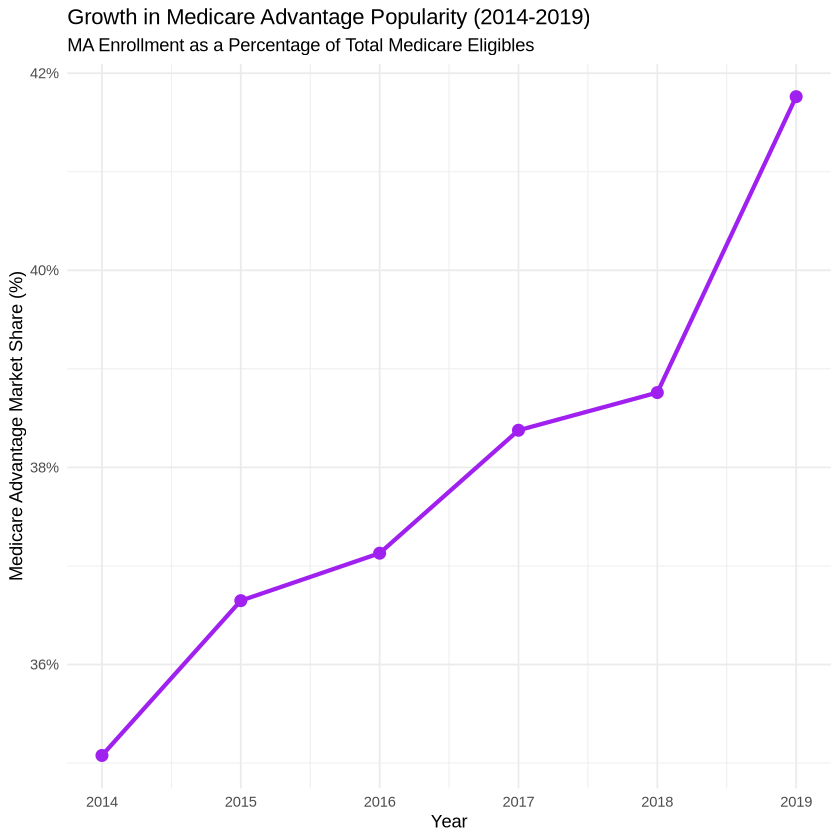

In [4]:
# Prepare popularity data
popularity_trend <- ma_summary %>%

group_by(year) %>%
summarize(

# Sum averages across all counties to get national total
national_enrolled = sum(avg_enrolled, na.rm = TRUE),
national_eligible = sum(avg_eligibles, na.rm = TRUE)
) %>%

# Calculate percentage
mutate(ma_share = (national_enrolled / national_eligible) * 100)

# Plot
ggplot(popularity_trend, aes(x = year, y = ma_share)) +
  geom_line(color = "purple", linewidth = 1.2) +
  geom_point(color = "purple", size = 3) +
  scale_x_continuous(breaks = 2014:2019) +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +
  labs(
    title = "Growth in Medicare Advantage Popularity (2014-2019)",
    subtitle = "MA Enrollment as a Percentage of Total Medicare Eligibles",
    x = "Year",
    y = "Medicare Advantage Market Share (%)",
  ) +
  theme_minimal()

# Question 5

In [5]:
# Prepare 2018 Data for Qs 5-10
ma_2018 <- ma_summary %>%
  filter(year == 2018) %>%
  group_by(fips) %>%
  mutate(
    total_county_enroll = sum(avg_enrollment, na.rm = TRUE),
    plan_share = if_else(total_county_enroll > 0, avg_enrollment / total_county_enroll, 0),
    county_hhi = sum((plan_share * 100)^2, na.rm = TRUE)
  ) %>%
  ungroup()

# Thresholds
hhi_dist <- ma_2018 %>% distinct(fips, county_hhi)
hhi_thresholds <- quantile(hhi_dist$county_hhi, probs = c(0.33, 0.66), na.rm = TRUE)

ma_2018 <- ma_2018 %>%
  mutate(market_type = case_when(
    county_hhi <= hhi_thresholds[1] ~ "Competitive",
    county_hhi >= hhi_thresholds[2] ~ "Uncompetitive"
  )) %>%
  filter(!is.na(market_type))

q5_results <- ma_2018 %>%
  group_by(market_type) %>%
  summarize(avg_bid = mean(bid, na.rm = TRUE))

print(q5_results)

# A tibble: 2 × 2
  market_type   avg_bid
  <chr>           <dbl>
1 Competitive      782.
2 Uncompetitive    787.


# Question 6

In [9]:
# Prepare data
ma_2018_quartiles <- ma_2018 %>%
filter(!is.na(avg_ffscost)) %>% 
  
# Define quartiles
mutate(ffs_quartile = ntile(avg_ffscost, 4)) %>%
  
# Create 4 binary indicator variables
mutate(
    q1_ind = if_else(ffs_quartile == 1, 1, 0),
    q2_ind = if_else(ffs_quartile == 2, 1, 0),
    q3_ind = if_else(ffs_quartile == 3, 1, 0),
    q4_ind = if_else(ffs_quartile == 4, 1, 0)
  )

# Summarize
q6_summary <- ma_2018_quartiles %>%
group_by(ffs_quartile, market_type) %>%
summarize(avg_bid = mean(bid, na.rm = TRUE), .groups = "drop") %>%
pivot_wider(names_from = market_type, values_from = avg_bid) %>%
rename(Quartile = ffs_quartile)

# Make table
q6_table <- q6_summary %>%
  rename(`FFS Cost Quartile` = Quartile) %>%
  mutate(
    Competitive = paste0("$", format(round(Competitive, 2), nsmall = 2)),
    Uncompetitive = paste0("$", format(round(Uncompetitive, 2), nsmall = 2))
  )

as.data.frame(q6_table)

FFS Cost Quartile,Competitive,Uncompetitive
<int>,<chr>,<chr>
1,$792.57,$810.79
2,$788.77,$785.95
3,$773.82,$772.39
4,$771.03,$784.54


# Question 7

In [8]:
# Prepare data
ma_2018_match <- ma_2018_quartiles %>%
  mutate(tr = if_else(market_type == "Uncompetitive", 1, 0)) %>%
  filter(!is.na(bid))

# 7a. Inverse Variance
m_inv_fit <- matchit(tr ~ ffs_quartile, data = ma_2018_match, 
                     method = "subclass", subclass = 4)
m_inv_data <- match.data(m_inv_fit)
model_inv <- lm(bid ~ tr, data = m_inv_data, weights = weights)

# 7b. Mahalanobis
m_maha_fit <- matchit(tr ~ ffs_quartile, data = ma_2018_match, 
                      method = "subclass", subclass = 4)
m_maha_data <- match.data(m_maha_fit)
model_maha <- lm(bid ~ tr, data = m_maha_data, weights = weights)

# 7c. Inverse Propensity Weighting
logit_ps <- glm(tr ~ q2_ind + q3_ind + q4_ind, family = binomial, data = ma_2018_match)
ma_2018_match$ps <- predict(logit_ps, type = "response")
ma_2018_match <- ma_2018_match %>%
  mutate(ipw_weight = if_else(tr == 1, 1/ps, 1/(1-ps)))
model_ipw <- lm(bid ~ tr, data = ma_2018_match, weights = ipw_weight)

# 7d. Linear Regression
model_ols <- lm(bid ~ tr * (q2_ind + q3_ind + q4_ind), data = ma_2018_match)
ols_res   <- avg_comparisons(model_ols, variables = "tr")

# Put results into table
q7_table <- data.frame(
  Statistic = c("Estimate", "Std. Error"),
  INV = c(coef(model_inv)["tr"], summary(model_inv)$coefficients["tr", 2]),
  MAH = c(coef(model_maha)["tr"], summary(model_maha)$coefficients["tr", 2]),
  IPW = c(coef(model_ipw)["tr"], summary(model_ipw)$coefficients["tr", 2]),
  OLS = c(ols_res$estimate, ols_res$std.error)
)

print(as.data.frame(q7_table %>% mutate(across(where(is.numeric), ~round(., 3)))), row.names = FALSE)

Warning message:
“Due to discreteness in the distance measure, fewer subclasses were
generated than were requested.”
Warning message:
“Due to discreteness in the distance measure, fewer subclasses were
generated than were requested.”


  Statistic   INV   MAH   IPW   OLS
   Estimate 6.479 6.479 6.919 6.919
 Std. Error 1.957 1.957 1.642 1.959


# Question 8

Results for question 8 across the different estimators are similar but not identical.
The slight difference between the matching group (INV and MAH) and the regression group (IPW and OLS) reflects the difference between 1-to-1 matching (may discard some control units) and full-sample estimators (uses all data). The estimates consistently show that uncompetitive markets lead to higher plan bids, with the effect ranging from $6.48$ to $6.92$ dollars.

# Question 9

In [17]:
model_9 <- lm(bid ~ tr * (ffs_costs + avg_enrollment), data = ma_2018_match)

# 2. Extract the Average Treatment Effect (ATE)
# This calculates how 'tr' affects 'bid' across the distribution of costs and enrollment
res_9 <- avg_comparisons(model_9, variables = "tr")

# 3. Create a clean comparison table
q9_comparison <- data.frame(
  Model = c("Quartile-Based (Q7)", "Continuous-Based (Q9)"),
  Estimate = c(ols_res$estimate, res_9$estimate),
  Std_Error = c(ols_res$std.error, res_9$std.error)
)

print(as.data.frame(q9_comparison %>% mutate(across(where(is.numeric), ~round(., 3)))), row.names = FALSE)

ERROR: Error in eval(predvars, data, env): object 'ffs_costs' not found
